In [1]:
import os
from m_generator import get_file_dict_libri
import numpy as np
import torch.nn.functional as F
import torch
import random
import matplotlib.pyplot as plt
import tuneThreshold

In [2]:
NPY_PATH = "../libri_emb/base/"
# NPY_PATH = "../libri_emb/trimmed/"

In [3]:
npy_list = os.listdir(NPY_PATH)
npy_list = [i for i in npy_list if str.find(i, "npy") != -1]

spk_emb_dict = {}
for emb in npy_list:
    emb_spk = int(emb[3:-4])
    emb_mat = np.load(NPY_PATH+emb)
    
    emb_mat = torch.tensor(emb_mat)
    spk_emb_dict[emb_spk] = emb_mat

spk_list = list(spk_emb_dict.keys())

In [4]:
# 단일 발화 EER - original

def eer_original(iter=10):
    d0_same = []
    d0_diff = []
    
    for i in range(iter):        
        for spk in spk_list:
            
            # same spk
            emb_mat = spk_emb_dict[spk]
            indices = random.sample(range(emb_mat.shape[0]), 2)
            emb1 = emb_mat[indices[0]]
            emb2 = emb_mat[indices[1]]
            
            emb1 = F.normalize(emb1, p=2, dim=1)
            emb2 = F.normalize(emb2, p=2, dim=1)
            d0_same.append(torch.cdist(emb1, emb2, p=2).mean().item())
            
            # diff spk
            indices = random.sample(spk_list, 2)
            emb_mat1 = spk_emb_dict[indices[0]]
            emb_mat2 = spk_emb_dict[indices[1]]
            emb1 = random.choice(emb_mat1)
            emb2 = random.choice(emb_mat2)
            
            emb1 = F.normalize(emb1, p=2, dim=1)
            emb2 = F.normalize(emb2, p=2, dim=1)
            d0_diff.append(torch.cdist(emb1, emb2, p=2).mean().item())

    fig, ax = plt.subplots()
    plt.boxplot([d0_same, d0_diff], positions=[1,0])
    ax.set_xlabel('Label')
    ax.set_ylabel('Distance')
    plt.show()

    d0 = d0_same + d0_diff
    s0 = [-1*i for i in d0]
    label_same = np.ones(len(d0_same))
    label_diff = np.zeros(len(d0_diff))
    label = list(np.concatenate([label_same, label_diff]))
    (tt0, eer0, fpr0, fnr0) = tuneThreshold.tuneThresholdfromScore(s0, label, [1, 0.1])
    
    return eer0

In [5]:
def eer_single_normalize(iter=10, flag=0):
    '''
    flag(0): normalize before frame-by average
    flag(1): normalize after frame-by average
    '''
    assert flag == 0 or flag == 1
    
    d1_same = []
    d1_diff = []
    
    for i in range(iter):
        for spk in spk_list:

            # same spk
            emb_mat = spk_emb_dict[spk] # n_utter, 10, 512
            indices = random.sample(range(emb_mat.shape[0]), 2)
            emb1 = emb_mat[indices[0]]
            emb2 = emb_mat[indices[1]]
            
            if flag == 0:                
                emb1 = F.normalize(emb1, p=2, dim=1)
                emb2 = F.normalize(emb2, p=2, dim=1)
                emb1 = emb1.mean(dim=0)
                emb2 = emb2.mean(dim=0)
            else:
                emb1 = emb1.mean(dim=0)
                emb2 = emb2.mean(dim=0)
                emb1 = F.normalize(emb1, p=2, dim=0)
                emb2 = F.normalize(emb2, p=2, dim=0)
            
            d1_same.append(torch.dist(emb1, emb2, p=2))
            
            
            
            # diff spk
            indices = random.sample(spk_list, 2)
            emb_mat1 = spk_emb_dict[indices[0]] # n_utter, 10, 512
            emb_mat2 = spk_emb_dict[indices[1]] # n_utter, 10, 512
            
            emb1 = random.choice(emb_mat1)
            emb2 = random.choice(emb_mat2)
            
            if flag == 0:
                emb1 = F.normalize(emb1, p=2, dim=1)
                emb2 = F.normalize(emb2, p=2, dim=1)
                emb1 = emb1.mean(dim=0)
                emb2 = emb2.mean(dim=0)     
            else:
                emb1 = emb1.mean(dim=0)
                emb2 = emb2.mean(dim=0)
                emb1 = F.normalize(emb1, p=2, dim=0)
                emb2 = F.normalize(emb2, p=2, dim=0)      

            d1_diff.append(torch.dist(emb1, emb2, p=2))

    fig, ax = plt.subplots()
    plt.boxplot([d1_same, d1_diff], positions=[1,0])
    ax.set_xlabel('Label')
    ax.set_ylabel('Distance')

    plt.show()

    d1 = d1_same + d1_diff
    s1 = [-1*i for i in d1]
    label_same = np.ones(len(d1_same))
    label_diff = np.zeros(len(d1_diff))
    label = list(np.concatenate([label_same, label_diff]))
    (tt1, eer1, fpr1, fnr1) = tuneThreshold.tuneThresholdfromScore(s1, label, [1, 0.1])
    
    return eer1

In [6]:
def eer_multiple_normalize(iter=10, flag=0, n_utter=3):
    
    '''
    flag(0): normalize before frame-by average
    flag(1): normalize between frame-by average and utterance-by average
    flag(2): normalize after utterance-by average
    '''
    
    assert flag == 0 or flag == 1 or flag == 2
    
    d2_same = []
    d2_diff = []
    for i in range(iter):
        for spk in spk_list:
            
            # same spk
            emb_mat = spk_emb_dict[spk] # n_utter, 10, 512
            
            indices = random.sample(range(emb_mat.shape[0]), 2*n_utter)
            indices1 = indices[0:n_utter]
            indices2 = indices[n_utter:2*n_utter]
            
            emb1 = torch.index_select(emb_mat, dim=0, index=torch.tensor(indices1)) # 3, 10, 512
            emb2 = torch.index_select(emb_mat, dim=0, index=torch.tensor(indices2)) # 3, 10, 512
            
            if flag == 0:
                emb1 = F.normalize(emb1, p=2, dim=2)
                emb1 = emb1.mean(dim=1)
                emb1 = emb1.mean(dim=0)
                emb2 = F.normalize(emb2, p=2, dim=2)
                emb2 = emb2.mean(dim=1)
                emb2 = emb2.mean(dim=0)
            elif flag == 1:
                emb1 = emb1.mean(dim=1)
                emb1 = F.normalize(emb1, p=2, dim=1)
                emb1 = emb1.mean(dim=0)
                emb2 = emb2.mean(dim=1)
                emb2 = F.normalize(emb2, p=2, dim=1)
                emb2 = emb2.mean(dim=0)
            else:
                emb1 = emb1.mean(dim=1)
                emb1 = emb1.mean(dim=0)
                emb1 = F.normalize(emb1, p=2, dim=0)
                emb2 = emb2.mean(dim=1)
                emb2 = emb2.mean(dim=0)
                emb2 = F.normalize(emb2, p=2, dim=0)
                
            d2_same.append(torch.dist(emb1, emb2, p=2))
            
            # diff spk
            indices = random.sample(spk_list, 2)
            emb_mat1 = spk_emb_dict[indices[0]] # n_utter, 10, 512
            emb_mat2 = spk_emb_dict[indices[1]] # n_utter, 10, 512
            indices1 = random.sample(range(emb_mat1.shape[0]), n_utter)
            indices2 = random.sample(range(emb_mat2.shape[0]), n_utter)
            
            emb1 = torch.index_select(emb_mat1, dim=0, index=torch.tensor(indices1)) # 3, 10, 512
            emb2 = torch.index_select(emb_mat2, dim=0, index=torch.tensor(indices2)) # 3, 10, 512
            
            if flag == 0:
                emb1 = F.normalize(emb1, p=2, dim=2)
                emb1 = emb1.mean(dim=1)
                emb1 = emb1.mean(dim=0)
                emb2 = F.normalize(emb2, p=2, dim=2)
                emb2 = emb2.mean(dim=1)
                emb2 = emb2.mean(dim=0)
            elif flag == 1:
                emb1 = emb1.mean(dim=1)
                emb1 = F.normalize(emb1, p=2, dim=1)
                emb1 = emb1.mean(dim=0)
                emb2 = emb2.mean(dim=1)
                emb2 = F.normalize(emb2, p=2, dim=1)
                emb2 = emb2.mean(dim=0)
            else:
                emb1 = emb1.mean(dim=1)
                emb1 = emb1.mean(dim=0)
                emb1 = F.normalize(emb1, p=2, dim=0)
                emb2 = emb2.mean(dim=1)
                emb2 = emb2.mean(dim=0)
                emb2 = F.normalize(emb2, p=2, dim=0)
                
            d2_diff.append(torch.dist(emb1, emb2, p=2))
        
    fig, ax = plt.subplots()
    plt.boxplot([d2_same, d2_diff], positions=[1,0])
    ax.set_xlabel('Label')
    ax.set_ylabel('Distance')
    plt.show()


    d2 = d2_same + d2_diff
    s2 = [-1*i for i in d2]
    label_same = np.ones(len(d2_same))
    label_diff = np.zeros(len(d2_diff))
    label = list(np.concatenate([label_same, label_diff]))
    (tt2, eer2, fpr2, fnr2) = tuneThreshold.tuneThresholdfromScore(s2, label, [1, 0.1])
    
    
    return eer2

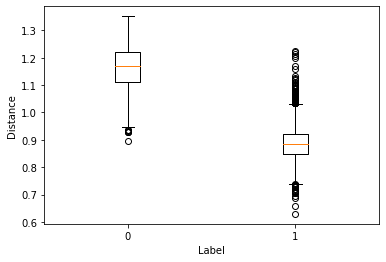

original method EER: 2.3597359735973598


In [10]:
print("original method EER:", eer_original(iter=10))

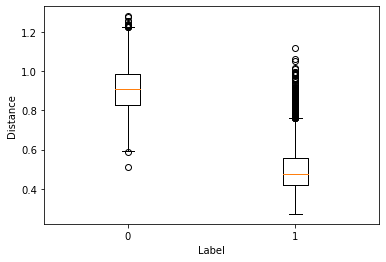

single method EER (normalize before average):  5.2805280528052805


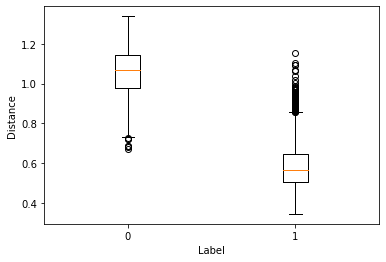

single method EER (normalize after average):  2.8877887788778875


In [11]:
print("single method EER (normalize before average): ", eer_single_normalize(iter=10, flag=0))
print("single method EER (normalize after average): ", eer_single_normalize(iter=10, flag=1))

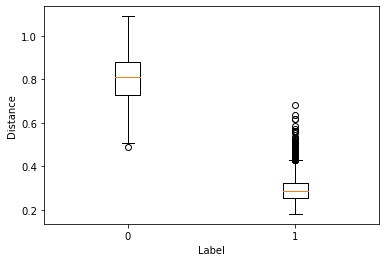

multiple method EER (normalize before frame-by avg):  0.214521452145211


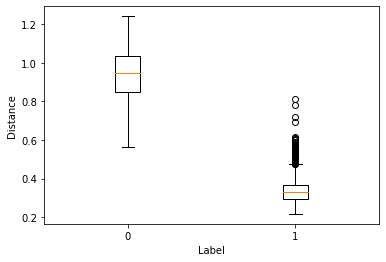

multiple method EER (normalize between frame-by avg and utter-by avg):  0.11551155115511551


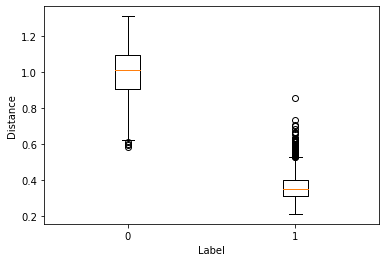

multiple method EER (normalize after utter-by avg):  0.14851485148514865


In [12]:
print("multiple method EER (normalize before frame-by avg): ", eer_multiple_normalize(iter=10, flag=0, n_utter=3))
print("multiple method EER (normalize between frame-by avg and utter-by avg): ", eer_multiple_normalize(iter=10, flag=1, n_utter=3))
print("multiple method EER (normalize after utter-by avg): ", eer_multiple_normalize(iter=10, flag=2, n_utter=3))

In [ ]:
# # 단일 발화 EER - original
# d0_same = []
# d0_diff = []
# for spk in spk_list:
    
#     # same spk
#     emb_mat = spk_emb_dict[spk]
#     indices = random.sample(range(emb_mat.shape[0]), 2)
#     emb1 = emb_mat[indices[0]]
#     emb2 = emb_mat[indices[1]]
    
#     # AP + softmax loss의 경우 wav의 10개 eval 구간에 따라 L2 normalization이 된다.
#     emb1 = F.normalize(emb1, p=2, dim=1)
#     emb2 = F.normalize(emb2, p=2, dim=1)
#     d0_same.append(torch.cdist(emb1, emb2, p=2).mean().item())
    
#     # diff spk
#     indices = random.sample(spk_list, 2)
#     emb_mat1 = spk_emb_dict[indices[0]]
#     emb_mat2 = spk_emb_dict[indices[1]]
#     emb1 = random.choice(emb_mat1)
#     emb2 = random.choice(emb_mat2)
    
#     # AP + softmax loss의 경우 wav의 10개 eval 구간에 따라 L2 normalization이 된다.
#     emb1 = F.normalize(emb1, p=2, dim=1)
#     emb2 = F.normalize(emb2, p=2, dim=1)
#     d0_diff.append(torch.cdist(emb1, emb2, p=2).mean().item())


# fig, ax = plt.subplots()
# plt.boxplot([d0_same, d0_diff], positions=[1,0])
# ax.set_xlabel('Label')
# ax.set_ylabel('Distance')
# plt.show()

# d0 = d0_same + d0_diff
# s0 = [-1*i for i in d0]
# label_same = np.ones(len(d0_same))
# label_diff = np.zeros(len(d0_diff))
# label = list(np.concatenate([label_same, label_diff]))
# (tt0, eer0, fpr0, fnr0) = tuneThreshold.tuneThresholdfromScore(s0, label, [1, 0.1])
# print(eer0)

In [ ]:
# # 단일 발화 EER

# '''
# (현재 방식) 10개 축으로 평균 후 정규화 vs
# 정규화 512축으로 한 후 평균
# '''


# d1_same = []
# d1_diff = []
# for spk in spk_list:

#     # same spk
#     # emb_mat = spk_emb_dict[spk].mean(dim=1) # (speech #, 512)
#     emb_mat = spk_emb_dict[spk]
#     emb_mat = F.normalize(emb_mat, p=2, dim=1)
    
#     indices = random.sample(range(emb_mat.shape[0]), 2)
#     emb1 = emb_mat[indices[0]]
#     emb2 = emb_mat[indices[1]]

#     # # AP + softmax loss의 경우 wav의 10개 eval 구간에 따라 L2 normalization이 된다.
#     # emb1 = F.normalize(emb1, p=2, dim=0)
#     # emb2 = F.normalize(emb2, p=2, dim=0)
#     d1_same.append(torch.dist(emb1, emb2, p=2))
    
    
    
    
    
#     # diff spk
#     indices = random.sample(spk_list, 2)
#     # emb_mat1 = spk_emb_dict[indices[0]].mean(dim=1)
#     # emb_mat2 = spk_emb_dict[indices[1]].mean(dim=1)
#     emb_mat1 = spk_emb_dict[indices[0]]
#     emb_mat2 = spk_emb_dict[indices[1]]
#     emb_mat1 = F.normalize(emb_mat1, p=2, dim=1)
#     emb_mat2 = F.normalize(emb_mat2, p=2, dim=1)
    
#     emb1 = random.choice(emb_mat1)
#     emb2 = random.choice(emb_mat2)

#     # # AP + softmax loss의 경우 wav의 10개 eval 구간에 따라 L2 normalization이 된다.
#     # emb1 = F.normalize(emb1, p=2, dim=0)
#     # emb2 = F.normalize(emb2, p=2, dim=0)
#     d1_diff.append(torch.dist(emb1, emb2, p=2))

# fig, ax = plt.subplots()
# plt.boxplot([d1_same, d1_diff], positions=[1,0])
# ax.set_xlabel('Label')
# ax.set_ylabel('Distance')

# plt.show()

# d1 = d1_same + d1_diff
# s1 = [-1*i for i in d1]
# label_same = np.ones(len(d1_same))
# label_diff = np.zeros(len(d1_diff))
# label = list(np.concatenate([label_same, label_diff]))
# (tt1, eer1, fpr1, fnr1) = tuneThreshold.tuneThresholdfromScore(s1, label, [1, 0.1])
# print(eer1)

In [ ]:
# 다발화 - single vector EER
d2_same = []
d2_diff = []
for spk in spk_list:
    # same spk
    emb_mat = spk_emb_dict[spk].mean(dim=1)
    index = random.choice(range(emb_mat.shape[0]))
    indices = list(range(emb_mat.shape[0]))
    indices.remove(index)
    emb1 = emb_mat[index]
    emb2 = torch.index_select(emb_mat, dim=0, index=torch.tensor(indices))
    emb2 = torch.mean(emb2, dim=0)
    
    # AP + softmax loss의 경우 wav의 10개 eval 구간에 따라 L2 normalization이 된다.
    emb1 = F.normalize(emb1, p=2, dim=0)
    emb2 = F.normalize(emb2, p=2, dim=0)
    d2_same.append(torch.dist(emb1, emb2, p=2))
    
    # diff spk
    indices = random.sample(spk_list, 2)
    emb1 = spk_emb_dict[indices[0]].mean(dim=1)
    emb2 = spk_emb_dict[indices[1]].mean(dim=1)
    emb1 = torch.mean(emb1, dim=0)
    emb2 = torch.mean(emb2, dim=0)
    
    # AP + softmax loss의 경우 wav의 10개 eval 구간에 따라 L2 normalization이 된다.
    emb1 = F.normalize(emb1, p=2, dim=0)
    emb2 = F.normalize(emb2, p=2, dim=0)
    d2_diff.append(torch.dist(emb1, emb2, p=2))
    # break
    
fig, ax = plt.subplots()
plt.boxplot([d2_same, d2_diff], positions=[1,0])
ax.set_xlabel('Label')
ax.set_ylabel('Distance')
plt.show()


d2 = d2_same + d2_diff
s2 = [-1*i for i in d2]
label_same = np.ones(len(d2_same))
label_diff = np.zeros(len(d2_diff))
label = list(np.concatenate([label_same, label_diff]))
(tt2, eer2, fpr2, fnr2) = tuneThreshold.tuneThresholdfromScore(s2, label, [1, 0.1])
print(eer2)